*Gabriele Filomena has readapted parts of this [notebook](https://github.com/mszell/geospatialdatascience/blob/main/unit08_openstreetmap/lecture08.ipynb)* for preparing this notebook.
Copyright (c) Michael Szell. Original sources include:
 
* OSMnx examples: https://github.com/gboeing/osmnx-examples
* pyrosm examples: https://pyrosm.readthedocs.io/en/latest/basics.html#read-street-networks

The **Lecture slides** can be found [here](https://github.com/GDSL-UL/wma/raw/main/lectures/w07.pdf).

This **lab**'s notebook can be downloaded from [here](https://github.com/GDSL-UL/wma/blob/main/labs/w07_osm.ipynb).

## What is OpenStreetMap?

OpenStreetMap is a free and open map service. It is a collaborative global effort to collect free and open geodata. *Source: [wiki.openstreetmap.org](https://wiki.openstreetmap.org/wiki/Logos)*. OpenStreetMap (OSM) is a global collaborative (crowd-sourced) database and project that aims at creating a free editable map of the world containing of information about our environment. It contains data about streets, buildings, different services, and landuse, to mention just a few.

OSM has more than 8 million registered users who contribute around 4 million changes daily.  Its database contains data that is described by [more than 7 billion nodes](http://wiki.openstreetmap.org/wiki/Stats) (that make up lines, polygons and other objects). While the most well-known side of OpenStreetMap is the map itself, the project is much more than that. OSM’s data can be used for many other purposes such as **routing**, **geocoding**, **education**, and **research**. OSM is also widely used for humanitarian response, e.g., in crisis areas (e.g. after natural disasters) and for fostering economic development. Read more about humanitarian projects that use OSM data from the [Humanitarian OpenStreetMap Team (HOTOSM) website](https://www.hotosm.org).

### Main tools in this lesson
#### OSMnx
This week we will explore a Python package called [`OSMnx`](https://github.com/gboeing/osmnx) that can be used to retrieve street networks from OpenStreetMap, and construct, analyse, and visualise them. `OSMnx` can also fetch most of the other data stored in OSM, such as building footprints, transport networks, parks, Points of Interest, etc..`OSMNx` also includes tools to find routes on a network downloaded from OpenStreetMap, and implements algorithms for finding shortest connections for walking, cycling, or driving.

To get an overview of the capabilities of the package, please refer to the following scientific article describing the package:

> Boeing, G. 2017. ["OSMnx: New Methods for Acquiring, Constructing, Analyzing, > and Visualizing Complex Street > Networks."](https://www.researchgate.net/publication/309738462_OSMnx_New_Methods_for_Acquiring_Constructing_Analyzing_and_Visualizing_Complex_Street_Networks)
> Computers, Environment and Urban Systems 65, 126-139.
> doi:10.1016/j.compenvurbsys.2017.05.004

#### NetworkX
We will also use [`NetworkX`](https://networkx.github.io/documentation//) to manipulate and analyse the street network data retrieved from OpenStreetMap. NetworkX is a Python package that can be used to create, manipulate, and study the structure, dynamics, and functions of complex networks. `OSMNx` is built on top `NetworkX` and `GeoPandas`.

In [10]:
import geopandas as gpd
import osmnx as ox
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

## Download, manipulate, and visualise OpenStreetMap data with OSMnx

A useful feature of `OSMNx` is its easy-to-use tools to download [OpenStreetMap](http://www.openstreetmap.org) data via the project’s [OverPass API](http://wiki.openstreetmap.org/wiki/Overpass_API). In this section, we will learn how to download and visualise the street network and additional data from OpenStreetMap covering different areas of interest.

### Boundaries from OpenStreetMap

`OSMnx` lets you download place boundary geometries from OpenStreetMap, project them, and plot them. For a more in-depth demonstration of querying by place, see [this notebook](03-graph-place-queries.ipynb).

<div class="alert alert-info" style="font-size:120%">

**Important**: <br>

Data downloaded from OSM are always in the WGS crs. You need to convert it for any type of spatial operation or computation to the appropriate coordinate reference system.
</div>

(-74.0542289, -73.8997471, 40.6695361, 40.8921299)

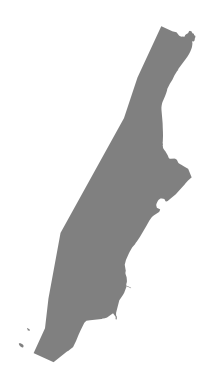

In [11]:
# get the boundary polygon for manhattan, project it, and plot it
city = ox.geocode_to_gdf("Manhattan")
ax = city.plot(fc="gray", ec="none")
ax.axis("off")

(22.03062615, 29.21406065, 41.08635925, 44.364547349999995)

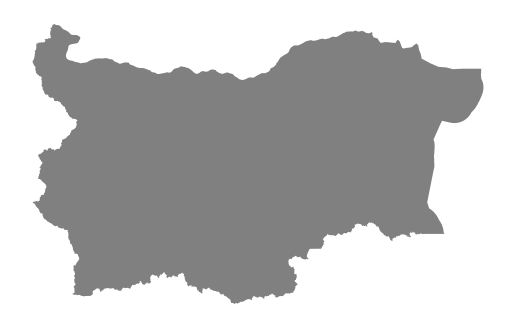

In [12]:
bulgaria = ox.geocode_to_gdf("Bulgaria")
ax = bulgaria.plot(fc="gray", ec="none")
ax.axis("off")

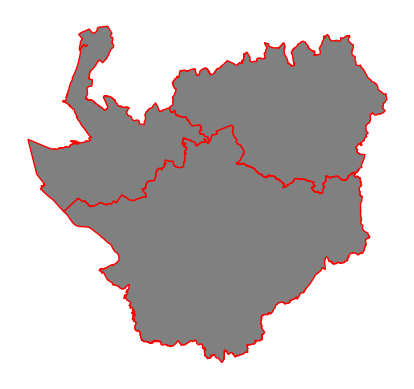

In [13]:
# get boundary polygons for several authorities in the UK, and plot
place_names = ["Merseyside", "Greater Manchester", "Cheshire"]
places = ox.geocode_to_gdf(place_names)
ax = places.plot(fc="gray", ec="red")
_ = ax.axis("off")

### Download and model Street Networks

The [`osmnx.graph`module](https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.graph) downloads data to construct a routable road network graph, based on an user-defined area of interest. This area of interest can be specified, for instance, using a place name, a bounding box, or a polygon. In the place name query, OSMnx uses the Nominatim Geocoding API. This means that place names should exist in the OpenStreetMap database (run a test search at [openstreetmap.org](https://www.openstreetmap.org/) or [nominatim.openstreetmap.org](https://nominatim.openstreetmap.org/ui/search.html)). `OSMnx`, amongst its several functionalities, lets you analyse, plot, and export the network in different file formats. The downloaded street networks are by default **directed** and preserve one-way directionality. For a more in-depth demonstration of creating street networks, see [this notebook](03-graph-place-queries.ipynb).

You can download a street network by providing OSMnx any of the following (demonstrated in the examples below):
  - a bounding box
  - a lat-lon point plus a distance
  - an address plus a distance
  - a place name or list of place names (to automatically geocode and get the boundary of)
  - a polygon of the desired street network's boundaries
  - a .osm formatted xml file

You can also specify several different network types:
  - `drive` - get drivable public streets (but not service roads)
  - `drive_service` - get drivable streets, including service roads
  - `walk` - get all streets and paths that pedestrians can use (this network type ignores one-way directionality)
  - `bike` - get all streets and paths that cyclists can use
  - `all` - download all non-private OSM streets and paths (this is the default network type unless you specify a different one)
  - `all_private` - download all OSM streets and paths, including private-access ones

#### Method #1: Passing a bounding box
This constructs the network from all the OSM nodes and ways within the bounding box. The plot function is built on `Matplotlib`, thus it follows the procedures and methods discussed in session II.

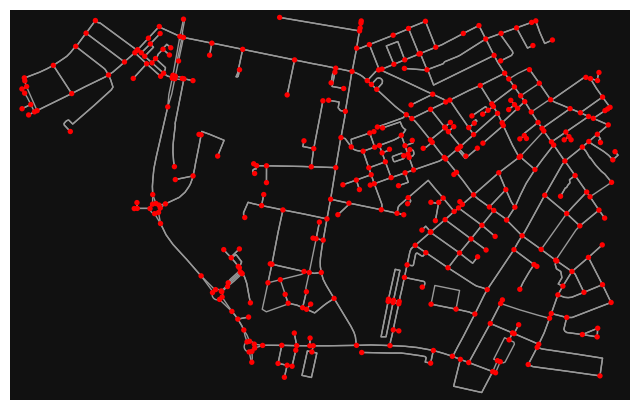

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [14]:
# define a bounding box in San Francisco
north, south, east, west = 37.79, 37.78, -122.41, -122.43
# define a bounding box around ITU
north, south, east, west = 55.6646, 55.6540, 12.5767, 12.6077

# create network from that bounding box
G = ox.graph_from_bbox(north, south, east, west, network_type="drive_service")
ox.plot_graph(G, node_color="r", figsize=(8, 8))

#### Method #2: Passing a lat-lon point and bounding box distance in meters
This creates a bounding box *n* meters North, South, East, and West of the point, then constructs the network from all the OSM nodes and ways within the bounding box. [Here's a useful tool for defining bboxes](https://bboxfinder.com)

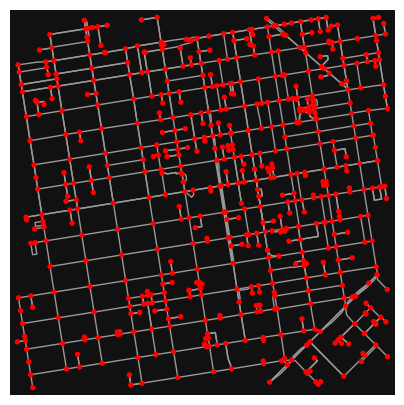

(<Figure size 500x500 with 1 Axes>, <Axes: >)

In [15]:
# define a point at the corner of California St and Mason St in SF
location_point = (37.791427, -122.410018)
# create bikeable network from point, inside bounding box of N, S, E, W each 750m from point
G = ox.graph_from_point(location_point, dist=750, dist_type="bbox", network_type="bike")
ox.plot_graph(G, node_color="r", figsize=(5,5))

#### Method #3: Passing a lat-lon point and *network* distance in meters

This creates a bounding box *n* meters North, South, East, and West of the point, then constructs the network from all the OSM nodes and ways within the bounding box. Then it truncates the network by removing all nodes further than *n* meters from the point along the network.

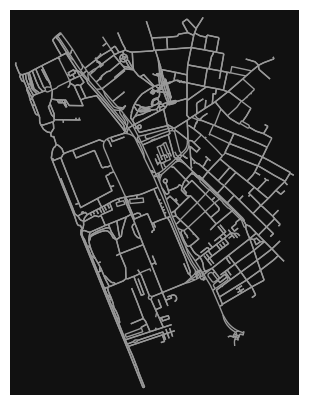

(<Figure size 500x500 with 1 Axes>, <Axes: >)

In [16]:
location_point = (53.40, -2.99)
# create network only of nodes within 750m along the network from point
G1 = ox.graph_from_point(location_point, dist=1000, dist_type="network")
ox.plot_graph(G1, node_color="none", figsize=(5,5))

*Note* the plot above shows the network within 750m (traveling distance along the network) from the `location_point`. By default, the `network_type` parameter value is `all`, meaning that we do not filter out paths that restrict certain types of traffic. This also means that one-way streets are honored as one-way and you cannot travel the wrong direction down them. Thus, the 750m takes into account only those nodes you can reach within 500m while only traveling in the allowed direction of the street. Instead (below), we can specify `network_type='walk'` to build a street network only of paths that walking is allowed on. This also makes every path bi-directional in the directed network, because you can walk in either direction on the sidewalk of a one-way street. The 750m now takes into account those nodes you can reach within 750m while traveling in either direction (even if it's a one-way street).

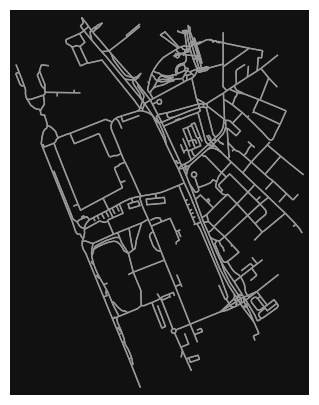

(<Figure size 500x500 with 1 Axes>, <Axes: >)

In [17]:
# create network only of nodes within 750m walking along the network from point, only walkable edges
G2 = ox.graph_from_point(location_point, dist=750, dist_type="network", network_type="walk")
ox.plot_graph(G2, node_color="none", figsize=(5,5))

#### Method #4, Passing an address and distance (*bounding box* or *network*) in meters
This geocodes the address, creates a bounding box, downloads the network, then truncates it by network distance (if distance_type='network').

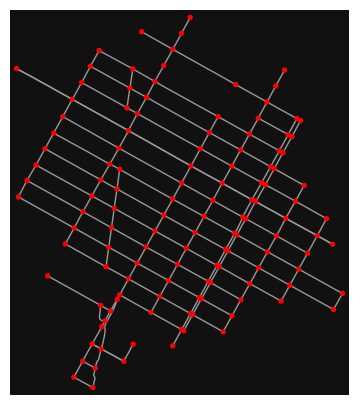

(<Figure size 500x500 with 1 Axes>, <Axes: >)

In [18]:
# network from address, including only nodes within 1km along the network from the address
G = ox.graph_from_address(address="350 5th Ave, New York, NY", dist=1000, dist_type="network", network_type="drive")
ox.plot_graph(G, node_color="r", figsize=(5,5))

#### Method #5: Passing a place name
This geocodes the place name, gets the place's boundary shape polygon and bounding box, downloads the network within the bounding box, then truncates it to the place's boundary polygon.

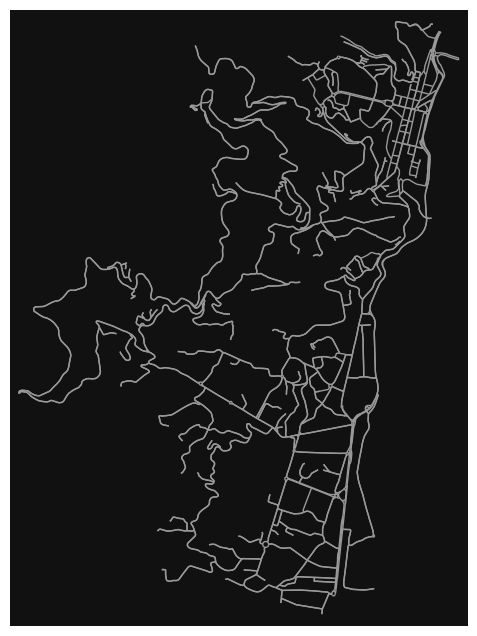

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [19]:
G = ox.graph_from_place("Bastia, Corsica", network_type="drive")
ox.plot_graph(G, node_color="none") # without plotting nodes

Be aware that this is a `MultiDiGraph`, i.e. a multigraph (parallel edges are possible) that is directed. Because there can be multiple links between a pair of nodes, each link is identified with a triple: (node1id, node2id, counter)

In [20]:
list(G.edges)[:10]

[(60370565, 338870652, 0),
 (60370565, 338870615, 0),
 (60370586, 338870618, 0),
 (60370599, 338870618, 0),
 (60370599, 60370602, 0),
 (60370602, 60370612, 0),
 (60370602, 60370599, 0),
 (60370612, 721266231, 0),
 (60370612, 60370602, 0),
 (60370622, 2358639572, 0)]

These values above correspond to `u`, `v` and `key`. More on that later, but, essentially, `u` is the id of the "from-node" and `v` the id of the "to-node"

#### Method #6 Passing a Poylgon in the WGS crs

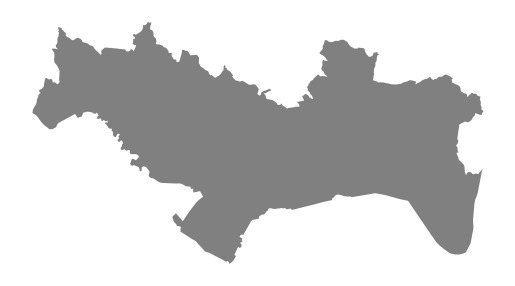

In [21]:
# get the boundary polygon for Sarajevo, and plot it
city = ox.geocode_to_gdf("Sarajevo, Bosnia")
city_proj = ox.project_gdf(city)
ax = city_proj.plot(fc="gray", ec="none")
ax.axis("off");

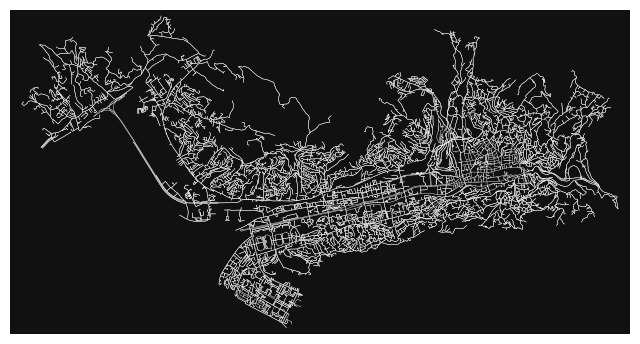

In [22]:
sarajevo = ox.geocode_to_gdf("Sarajevo, Bosnia")
polygon = sarajevo["geometry"].iloc[0]

G = ox.graph_from_polygon(polygon, network_type="drive_service")
ox.plot_graph(G, node_size=0, edge_color="w", edge_linewidth=0.3);

### Simplifying and Cleaning the Street Network Topology

Simplification is normally done by `OSMnx` automatically under the hood, but we can break it out to see how it works. OpenStreetMap nodes are weird. They include intersections, but they also include all the points along a single block where the street curves. The latter are not nodes in the graph theory sense, so we remove them algorithmically and consolidate the set of edges between "true" network nodes into a single edge. There are two simplification modes, strict and non-strict. The main difference is that unlike strict mode, non-strict mode allows simplification to an "expansion graph" (i.e., if the graph were undirected, nodes with degree 2 as long as the incident edges have different OSM IDs).

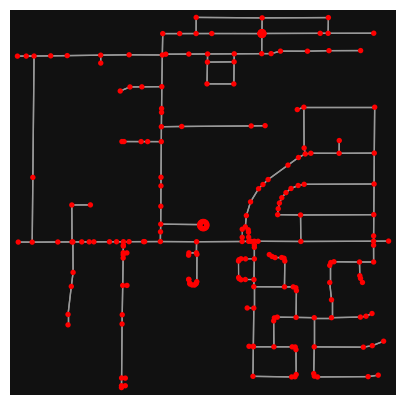

(<Figure size 500x500 with 1 Axes>, <Axes: >)

In [24]:
# create a network around some (lat, lng) point but do not simplify it yet
location_point = (33.299896, -111.831638)
G = ox.graph_from_point(location_point, network_type="drive_service", dist=500, simplify=False)
ox.plot_graph(G, node_color="r", figsize=(5,5))

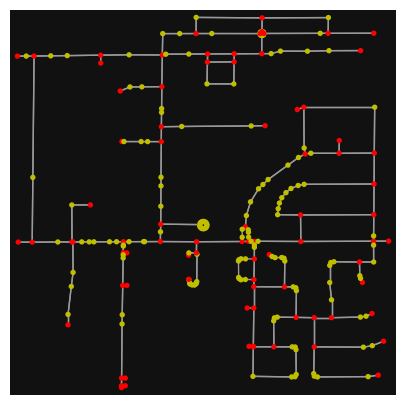

In [25]:
# turn off strict mode and see what nodes we'd remove, in yellow
colors = ["r" if ox.simplification._is_endpoint(G, node) else "y" for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=colors, figsize=(5,5))

The yellow markers above are OSM nodes. We'll remove the nodes in yellow as they're not real network nodes (intersections/dead-ends).

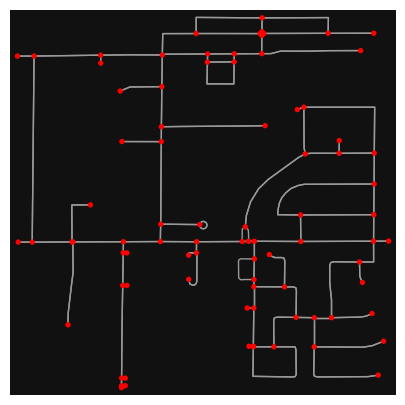

(<Figure size 500x500 with 1 Axes>, <Axes: >)

In [16]:
# simplify the network
G = ox.simplify_graph(G)
ox.plot_graph(G, node_color="r", figsize=(5,5))

#### Optional: Complex intersection consolidation

Many real-world street networks feature complex intersections and traffic circles, resulting in a cluster of graph nodes where there is really just one true intersection. Similarly, divided roads are often represented by separate centerline edges: the intersection of two divided roads thus creates 4 nodes, representing where each edge intersects a perpendicular edge, but these 4 nodes represent a single intersection in the real world. Traffic circles similarly create a cluster of nodes where each street's edge intersects the roundabout.

`OSMnx` can consolidate nearby intersections and optionally rebuild the graph's topology.

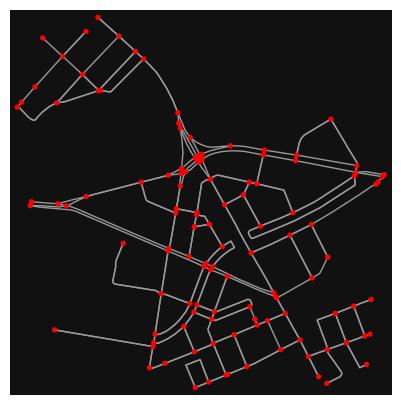

(<Figure size 500x500 with 1 Axes>, <Axes: >)

In [17]:
# get a street network and plot it with all edge intersections
point = 55.667708, 12.596266
G = ox.graph_from_point(point, network_type="drive", dist=500)
ox.plot_graph(G, node_color="r", figsize=(5,5))

Notice the complex intersections creating clusters of nodes.

We'll specify that any nodes with 15 meter buffers of each other in this network are part of the same intersection. Adjust this tolerance based on the street design standards in the community you are examining, and use a projected graph to work in meaningful units like meters. We'll also specify that we do not want dead-ends returned in our list of consolidated intersections.

In [18]:
# get a GeoSeries of consolidated intersections
G_proj = ox.project_graph(G)
intersections = ox.consolidate_intersections(G_proj, rebuild_graph=False, tolerance=15, dead_ends=False)
# compare to number of nodes in original graph
print(len(intersections), "vs", len(G))

73 vs 122


Note that these cleaned up intersections give us more accurate intersection counts and densities, but do not alter or integrate with the network's topology. To do that, we need to **rebuild the graph**.

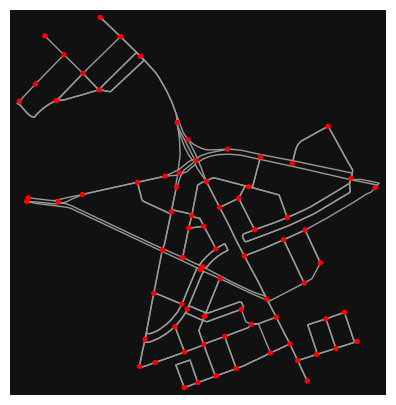

(<Figure size 500x500 with 1 Axes>, <Axes: >)

In [19]:
# consolidate intersections and rebuild graph topology
# this reconnects edge geometries to the new consolidated nodes
cleaned = ox.consolidate_intersections(G_proj, rebuild_graph=True, tolerance=15, dead_ends=False)
ox.plot_graph(cleaned, node_color="r", figsize=(5,5))

Notice how many nodes are merged into a new single centroid node, with edge geometries extended to connect to it. Similar consolidation occurs at the intersection of the divided roads. 

**Note**

Running `consolidate_intersections` with `rebuild_graph=True` may yield somewhat (but not very) different intersection counts/densities compared to `rebuild_graph=False`. The difference lies in that the latter just merges buffered node points that overlap, whereas the former checks the topology of the overlapping node buffers before merging them. This prevents topologically remote but spatially proximate nodes from being merged. For example:
- A street intersection may lie directly below a freeway overpass's intersection with an on-ramp. We would not want to merge these together and connect  their edges: they are distinct junctions in the system of roads.
- In a residential neighbourhood, a bollarded street may create a dead-end immediately next to an intersection or traffic circle. We would not want to merge this dead-end with the intersection and connect their edges.

These examples illustrate (two-dimensional) geometric proximity, but topological remoteness. Accordingly, in some situations we may expect higher intersection counts when using `rebuild_graph=True` because it is more cautious with merging in these cases. The trade-off is that it has higher time complexity than `rebuild_graph=False`.

### From OSMNX to NetworkX and Geopandas Classes

Now, we have seen how to use some basic `osmnx` functions to obtain a graph representation of the street network. While this is simple and straightforward, I advise working on the street network represented as `geopandas.GeoDataFrame`s and `networkx` graphs. While at the beginning this may be more tedious, it also gives us much more control, both in terms of visualisation and analysis depth. Before proceeding, it is important to keep in mind what type of graphs can be modelled through OSMNx and NetworkX, and what that means for the infrastructure we are modelling.

<img src="../labs_img/graph_types.png"  width="70%">

Have a look at NetworkX [documentation](https://networkx.org/documentation/stable/reference/classes/index.html) for details.

**By default, the graphs obtained through OSMNX are 'MultiDiGraph'**

In [20]:
siracusa_graph = ox.graph_from_address("Largo XXV Luglio, Siracusa", network_type="all", dist = 2500)
sicily_epsg = 'EPSG:23030'
nodes = ox.graph_to_gdfs(siracusa_graph, nodes=True, node_geometry=True, edges = False).to_crs(crs = 23030)
edges = ox.graph_to_gdfs(siracusa_graph, nodes=False, edges =  True, fill_edge_geometry=True).to_crs(crs = 23030)

<Axes: >

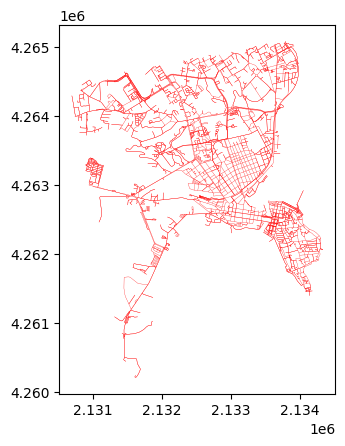

In [21]:
edges.plot(lw = 0.2, color = 'red')

We can visualise major roads on top of the street network:

<Axes: >

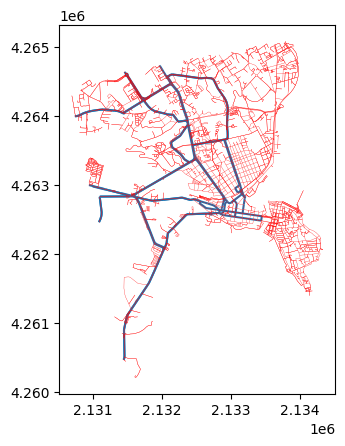

In [22]:
ax = edges[edges.highway.isin(['primary', 'secondary'])].plot()
edges.plot(ax = ax, lw = 0.2, color = 'red')

In [23]:
edges.head()

osmid      highway maxspeed  oneway  \
u        v          key                                                         
33566408 297074052  0                 828152472    secondary       50   False   
         9130394527 0                   5028297  residential       50    True   
         7876226633 0    [828152472, 836932525]    secondary       50   False   
33566411 8185067296 0                 881159784    secondary       50    True   
         33566412   0                  28114161  residential      NaN    True   

                        reversed  length  \
u        v          key                    
33566408 297074052  0      False  63.755   
         9130394527 0      False  46.925   
         7876226633 0       True  26.804   
33566411 8185067296 0      False   3.544   
         33566412   0      False  62.841   

                                                                  geometry  \
u        v          key                                                      
33566408 297074052  0    LINESTRING (2132529.446 4262765.911, 2132466.8...   
         9130394527 0    LINESTRING (2132529.446 4262765.911, 2132535.5...   
         7876226633 0    LINESTRING (2132529.446 4262765.911, 2132538.7...   
33566411 8185067296 0    LINESTRING (2133165.090 4262581.928, 2133165.4...   
         33566412   0    LINESTRING (2133165.090 4262581.928, 2133163.3...   

                                         name lanes junction  ref bridge  \
u        v          key                                                    
33566408 297074052  0                     NaN   NaN      NaN  NaN    NaN   
         9130394527 0                     NaN   NaN      NaN  NaN    NaN   
         7876226633 0    Via Francesco Crispi   NaN      NaN  NaN    NaN   
33566411 8185067296 0                     NaN     2      NaN  NaN    NaN   
         33566412   0          Via Nino Bixio   NaN      NaN  NaN    NaN   

                        access service tunnel width  
u        v          key                              
33566408 297074052  0      NaN     NaN    NaN   NaN  
         9130394527 0      NaN     NaN    NaN   NaN  
         7876226633 0      NaN     NaN    NaN   NaN  
33566411 8185067296 0      NaN     NaN    NaN   NaN  
         33566412   0      NaN     NaN    NaN   NaN

In [25]:
nodes.head()

,y,x,street_count,highway,geometry
osmid,,,,,
33566408,37.068451,15.280819,3,NaN,POINT (2132529.446 4262765.911)
33566411,37.065793,15.287216,4,NaN,POINT (2133165.090 4262581.928)
33566412,37.065258,15.286985,3,NaN,POINT (2133156.199 4262517.746)
33566413,37.064692,15.286909,3,NaN,POINT (2133162.078 4262452.755)
33566854,37.060586,15.293191,3,NaN,POINT (2133819.897 4262104.005)


As you can see an edge's index is a `MultiIndex` given by `u`, `v`, and `key`. `u` and `v` in `networkx` language stand for "from-node" and "to-node". `key`, on the other hand, indicates whether more than one edge links `u` and `v`. When a pair of `u` and `v` nodes have more then one edge, every other edge will have an incremental `key` value (the second one 1, the third one 2, etc., very rare that there are more than two edges per pair of nodes). This means that we are dealing with a `MultiGraph` representation of the street network. In other words, we have two street segments connecting the same two nodes in different directions. This could, for example, indicate that the directionality is accounted for (one-way segments). Based on our objective and analysis, such an aspect might be relevant, or not.

#### (Re)converting to a `MultiGraph`/`MultiDiGraph`
First, we get rid of the `pandas` `MultiIndex` and we verify whether we are working with bidirectional edges.

In [26]:
edges.reset_index(inplace = True)
edges['key'].sum()

96

In [27]:
import networkx as nx
Mg = nx.MultiGraph()   
Mg.add_nodes_from(nodes.index)

Copying the nodes' attributes (this step is not particularly essential unless we need some information associated with the nodes that we want to use when executing `networkx` methods). Anything else we can rely on the information that is in the `GeoDataFrame`.

In [28]:
# add the nodes' attributes
attributes = nodes.to_dict()

for attribute_name in nodes.columns:
    if nodes[attribute_name].apply(lambda x: type(x) == list).any(): 
        continue 
    # only add this attribute to nodes which have a non-null value for it
    attribute_values = {k:v for k, v in attributes[attribute_name].items() if pd.notnull(v)}
    nx.set_node_attributes(Mg, name=attribute_name, values=attribute_values)

We do something similar for edges. In this case, it is more likely that there is information that we want to copy, e.g. the length of the edges, into the `MultiGraph`.

In [29]:
edges['length'] = edges.geometry.length

# add the edges and attributes that are not u, v, key, null, or of type list
## u, v, and key are added directly as you can see from the last line
for row in edges.itertuples():
    attrs = {label: value for label, value in row._asdict().items() if (label not in ['u', 'v', 'key']) and 
             (isinstance(value, list) or pd.notnull(value))}
    Mg.add_edge(row.u, row.v, key=row.key, **attrs)

#### Converting to a `Graph`/`DiGraph`

In this case, we need to get rid of the "duplicated" edges. For the sake of simplicity, we remove al the edges with `key` equal to 1. This is a very rough approach.

In [30]:
edges_copy = edges[edges.key == 0].copy()
G = nx.Graph()   
G.add_nodes_from(nodes.index)

Then, we copy the attributes with the same approach used before, although, this time, without adding the `key` value to the edges. The function `add_edge` of the class the `graph` does not take the `key` argument as there could be only one edge between two nodes.

In [31]:
# ignore fields containing values of type list
attributes = nodes.to_dict()

for attribute_name in nodes.columns:
    if nodes[attribute_name].apply(lambda x: type(x) == list).any(): 
        continue    
    # only add this attribute to nodes which have a non-null value for it
    attribute_values = {k: v for k, v in attributes[attribute_name].items() if pd.notnull(v)}
    nx.set_node_attributes(G, name=attribute_name, values=attribute_values)

# add the edges and attributes that are not u, v, null, or of type list
## u, and v are added directly as you can see from the last line
for row in edges_copy.itertuples():
    attrs = {label: value for label, value in row._asdict().items() if (label not in ['u', 'v']) and (isinstance(value, list) or pd.notnull(value))}
    G.add_edge(row.u, row.v, **attrs)

And just to be sure:

In [32]:
len(list(G.nodes())) == len(nodes)

True

## Routing with NetworkX

Both with `osmnx` and `networkx` we can compute paths across the network, of different kinds, with different weights and methods (see [here](https://networkx.org/documentation/stable/reference/algorithms/shortest_paths.html). Shortest paths, while they seem to allude to an explicit reference to distance or time, may be computed in relation to other weights or costs, based on the purposes of the user. 

In [33]:
import random
# Get a list of all nodes in the graph
nodes = list(G.nodes())

# Select a random node
origin_node = random.choice(nodes)

while(True):
    destination_node = random.choice(nodes)
    if destination_node != origin_node:
        break

path_nodes = nx.shortest_path(G, source=origin_node, target=destination_node, weight='length', method='dijkstra')

`shortest_path`, the simplest function for computing shortest paths in `networkx`, returns the list of nodes traversed by the path, including the origin and the destination nodes. We have to transform the sequence of nodes into a sequence of edges to get the corresponding route. 

In [34]:
path_edges = [(path_nodes[i], path_nodes[i + 1]) for i in range(len(path_nodes) - 1)] 
path_edges[0]

(8127132944, 607017640)

When we look at the elements of the edges sequence, we can see that this is a tuple containing the index of the `u` and `v` nodes that the edge links together. This is the `networkx` representations of an edge inside a `graph`. 

In [35]:
path_edges[0]

(8127132944, 607017640)

However, for that edge, we want to get the attribute that refers to the index in the `edges_copy` `GeoDataFrame`. For that, We use a list comprehension.

In [40]:
G[33566408][297074052]

{'Index': 429,
 'key': 0,
 'osmid': 828152472,
 'highway': 'secondary',
 'maxspeed': '50',
 'oneway': False,
 'reversed': True,
 'length': 65.9190093168531,
 'geometry': <LINESTRING (2132466.835 4262786.532, 2132529.446 4262765.911)>}

In [41]:
path_edges = [G.edges[edge]['Index'] for edge in path_edges]

And then we can plot the route.

<Axes: >

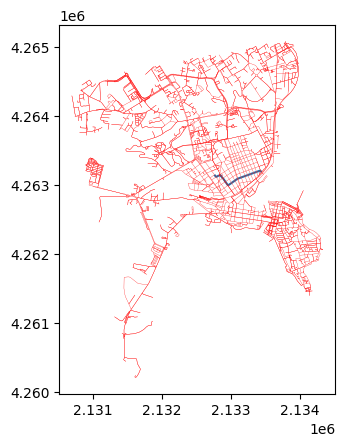

In [42]:
ax = edges_copy[edges_copy.index.isin(path_edges)].plot()
edges_copy.plot(ax = ax, lw = 0.2, color = 'red')

<div class="alert alert-success">

**Exercise**:

Compute different shortest paths between a node (1) of your choice and a set of 20 other random nodes, for a driver and a walker. Visualise and compare the results. In order to differentiate the users, you are expected to consider their travelling speeds, in relation to the speed limit of the edges. Consider that, at least for the driver, you may want to do that in a `MultiDiGraph`. 

You can use as case-study one of the graphs used above for Siracusa (Italy) or Sarajevo (Bosnia). Otherwise, just pick a city you like.
</div>

## Fetching other networks with OSMNX

When downloading graphs, one can also pass a `custom_filter` to specify what OSM ways/routes/links they want represented in their graph. This would override the fact that, by default, graph functions in `osmnx` fetch street networks.

From `osmnx` documentation:
`custom_filter` (string) – a custom ways filter to be used instead of the network_type presets e.g., `[“power”~”line”]` or `[“highway”~”motorway|trunk”]`. 

This method does not work with bus services, since they are not stored in OpenStreetMap Data as Links but rather relations. See [here](https://wiki.openstreetmap.org/wiki/Buses) for more info.

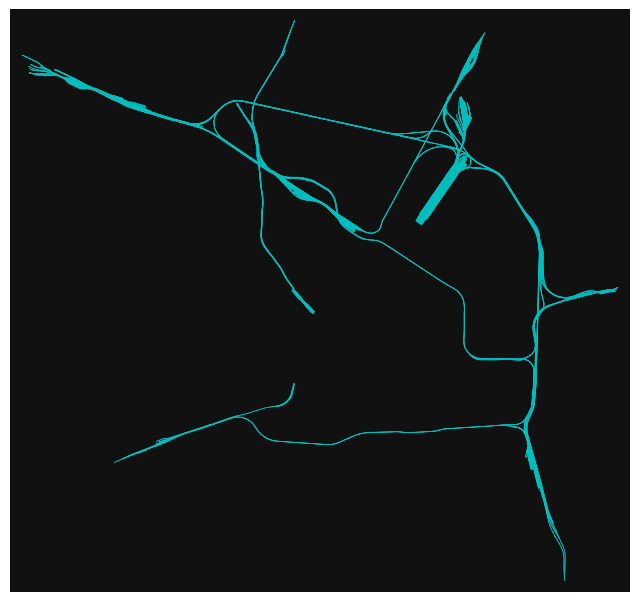

In [7]:
# railway infrastructures
place = "Milan, Italy"
G = ox.graph_from_place(place, custom_filter='["railway"~"rail"]')
ox.plot_graph(G, edge_color="c", edge_linewidth=0.5, node_size=0);

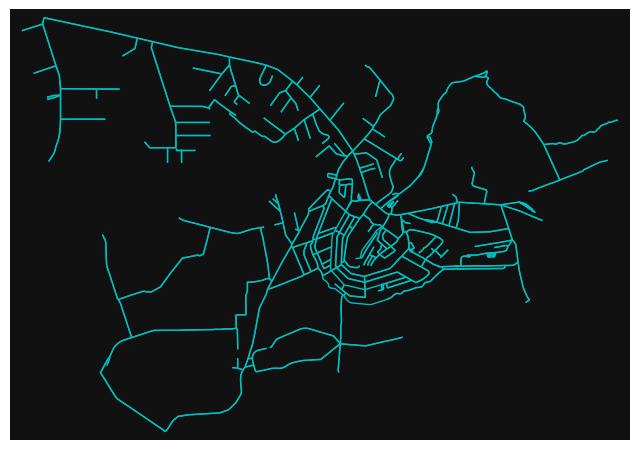

In [160]:
# network of the canals of amsterdam
place = "Amsterdam, Netherlands"
G = ox.graph_from_place(place, custom_filter='["waterway"~"canal"]')
ox.plot_graph(G, edge_color="c", edge_linewidth=1, node_size=0);

## Retrieving Other OSM data

OSMNx power also lies on the fact that it allows obtaining any other element represented in OpenStreetMap data.
You can use the same methods described above for graphs. Instead of using `graph_from_place`, you would use, for example, `features_from_place`, `features_from_address`, etc.

#### Fetching Building Footprints

In [4]:
# Specify the location and the data type
place = 'Torino, Italy'
tags = {'building': True}

# Fetch building footprints
buildings = ox.features_from_place(place, tags=tags)
buildings = buildings[buildings.geometry.geom_type == 'Polygon']

# Plot the building footprints
ax = buildings.plot(figsize=(6, 6), color = 'orange')
ax.set_title('Building Footprints in Torino, Italy')

#### Water bodies

Text(0.5, 1.0, 'Waterbodies in Torino, Italy')

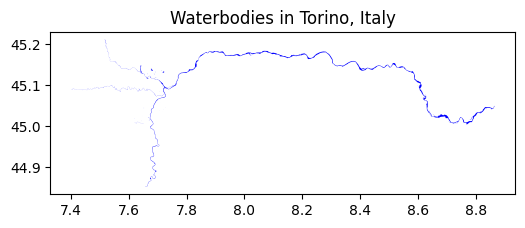

In [146]:
# Tags for waterbodies
water_tags = {'natural': ['water']}

# Fetch water bodies
waterbodies = ox.features_from_place(place, tags=water_tags)

# Plot water bodies
ax = waterbodies.plot(figsize=(6, 6), color='blue')
ax.set_title('Waterbodies in Torino, Italy')

#### POIs

Text(0.5, 1.0, 'Points of Interest in Torino, Italy')

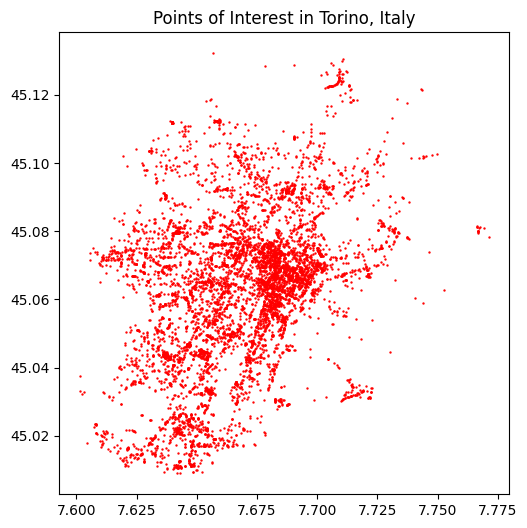

In [152]:
# Tags for POIs
poi_tags = {'amenity': True}

# Fetch POIs
pois = ox.features_from_place(place, tags=poi_tags)
pois = pois[pois.geometry.geom_type == 'Point']
# Plot POIs
ax = pois.plot(figsize=(6, 6), color='red', markersize = 0.5)
ax.set_title('Points of Interest in Torino, Italy')

#### Public Transport Bus Stops

Text(0.5, 1.0, 'Public Transport Stops in Torino, Italy')

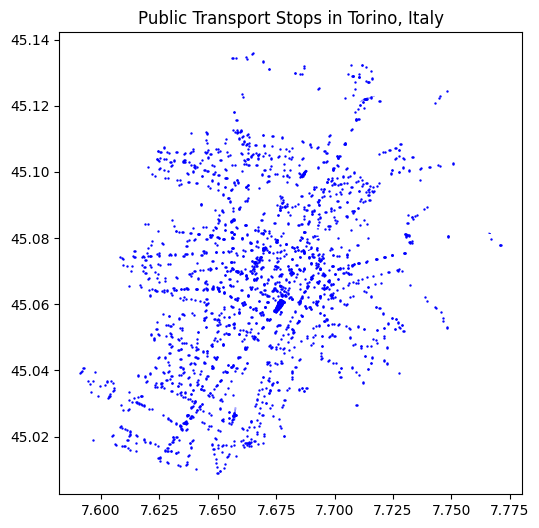

In [164]:
# Tags for public transport
tags = {'public_transport': True}

# Fetch public transport routes
pt_stops = ox.features_from_place(place, tags=tags)

# Plot bus routes
ax = pt_stops.plot(figsize=(6, 6), color='blue', markersize = 0.5)
ax.set_title('Public Transport Stops in Torino, Italy')